#Introduction
Welcome

In this notebook I will be training transformers based models to perform named entity recognition which means that every word is classified as one of the entities listed below

O = no entity

geo = Geographical Entity

org = Organization

per = Person

gpe = Geopolitical Entity

tim = Time indicator

art = Artifact

eve = Event

nat = Natural Phenomenon

In [ ]:
%%capture
!pip install datasets evaluate transformers[sentencepiece]
!apt install git-lfs
!pip install ipywidgets==7.7.1
!pip install torchinfo
!pip install seqeval
!pip install wandb

In [ ]:
!nvidia-smi

Mon Nov 21 15:46:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import numpy as np
from datasets import Dataset
from collections import defaultdict
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification
from huggingface_hub import create_repo
from datasets import load_metric
from torchinfo import summary
from transformers import TrainingArguments
from transformers import Trainer
import evaluate
from huggingface_hub import notebook_login
import wandb

I will store models on huggingface hub and track my experiments with Weights&Biases

In [ ]:
notebook_login()

In [ ]:
wandb.login()

In [ ]:
%env WANDB_PROJECT=ner

#Data exploration and preprocessing

Dataset I'm using https://www.kaggle.com/rajnathpatel/ner-data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Kaggle_datasets/ner.csv')

In [ ]:
df.head()

,text,labels
0,Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...
1,Iranian officials say they expect to get acces...,B-gpe O O O O O O O O O O O O O O B-tim O O O ...
2,Helicopter gunships Saturday pounded militant ...,O O B-tim O O O O O B-geo O O O O O B-org O O ...
3,They left after a tense hour-long standoff wit...,O O O O O O O O O O O
4,U.N. relief coordinator Jan Egeland said Sunda...,B-geo O O B-per I-per O B-tim O B-geo O B-gpe ...


I'm splitting text and labels strings on white spaces so it will be easier to work with them later

In [ ]:
df = df.applymap(lambda x: x.split())

In [ ]:
df.head()

,text,labels
0,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo..."
1,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,..."
2,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O..."
3,"[They, left, after, a, tense, hour-long, stand...","[O, O, O, O, O, O, O, O, O, O, O]"
4,"[U.N., relief, coordinator, Jan, Egeland, said...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo..."


Splitting on white spaces might not work on all of the examples so I will only keep those with matching lengths

In [ ]:
alligned_indexes = []
lenghts = []
for index, row in df.iterrows():
  if len(row['text']) == len(row['labels']):
    alligned_indexes.append(index)
    lenghts.append(len(row['text']))

In [ ]:
label2id = {
    'O': 0, 'B-per': 1, 'I-per': 2, 'B-nat': 3, 'I-nat': 4, 'B-tim': 5, 'I-tim': 6, 'B-gpe': 7, 'I-gpe': 8, 'B-org': 9, 'I-org': 10, 'B-art': 11, 'I-art': 12,  'B-eve': 13, 'I-eve': 14, 'B-geo': 15, 'I-geo': 16
}

B at the beginning means that there will be a sequence of the same labels and this word is first, all other labels in that sequence are appended with I

B at the beginning means that this word is a beginning of a sequence of the same labels

In [ ]:
id2label = {v: k for k, v in label2id.items()}
id2label

{0: 'O',
 1: 'B-per',
 2: 'I-per',
 3: 'B-nat',
 4: 'I-nat',
 5: 'B-tim',
 6: 'I-tim',
 7: 'B-gpe',
 8: 'I-gpe',
 9: 'B-org',
 10: 'I-org',
 11: 'B-art',
 12: 'I-art',
 13: 'B-eve',
 14: 'I-eve',
 15: 'B-geo',
 16: 'I-geo'}

In [ ]:
lenghts = pd.Series(data=lenghts)

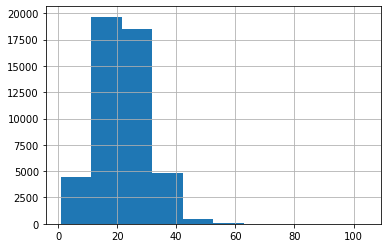

In [ ]:
lenghts.hist()

Majority of samples have between 10 and 30 words

In [ ]:
lenghts.describe()

count    47946.000000
mean        21.861532
std          7.961603
min          1.000000
25%         16.000000
50%         21.000000
75%         27.000000
max        104.000000
dtype: float64

In [ ]:
df = df.iloc[alligned_indexes]

In [ ]:
label_count = defaultdict(None)

In [ ]:
for key in label2id.keys():
  label_count[key] = 0

In [ ]:
for col in df['labels']:
  for label in col:
    label_count[label] += 1

label_count

defaultdict(None,
            {'O': 887550,
             'B-per': 16986,
             'I-per': 17248,
             'B-nat': 200,
             'I-nat': 50,
             'B-tim': 20330,
             'I-tim': 6525,
             'B-gpe': 15864,
             'I-gpe': 198,
             'B-org': 20134,
             'I-org': 16779,
             'B-art': 402,
             'I-art': 297,
             'B-eve': 308,
             'I-eve': 253,
             'B-geo': 37637,
             'I-geo': 7412})

There are some classes with less than 1000 samples so I'll get rid of them as they probably are unlernable

In [ ]:
id2label = {
    0: 'O',
    1: 'B-per',
    2: 'I-per',
    3: 'B-tim',
    4: 'I-tim',
    5: 'B-gpe',
    6: 'I-gpe',
    7: 'B-org',
    8: 'I-org',
    9: 'B-geo',
    10: 'I-geo'
}

In [ ]:
label2id = {v: k for k, v in id2label.items()}
label2id

{'O': 0,
 'B-per': 1,
 'I-per': 2,
 'B-tim': 3,
 'I-tim': 4,
 'B-gpe': 5,
 'I-gpe': 6,
 'B-org': 7,
 'I-org': 8,
 'B-geo': 9,
 'I-geo': 10}

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Kaggle_datasets/ner.csv')

In [ ]:
df['labels'] = df['labels'].map(lambda x: x.replace('B-nat', 'O'))
df['labels'] = df['labels'].map(lambda x: x.replace('I-nat', 'O'))
df['labels'] = df['labels'].map(lambda x: x.replace('B-eve', 'O'))
df['labels'] = df['labels'].map(lambda x: x.replace('I-eve', 'O'))
df['labels'] = df['labels'].map(lambda x: x.replace('B-art', 'O'))
df['labels'] = df['labels'].map(lambda x: x.replace('I-art', 'O'))

In [ ]:
df = df.applymap(lambda x: x.split())

In [ ]:
alligned_indexes = []
lenghts = []
for index, row in df.iterrows():
  if len(row['text']) == len(row['labels']):
    alligned_indexes.append(index)
    lenghts.append(len(row['text']))

In [ ]:
df = df.iloc[alligned_indexes]

In [ ]:
dataset = Dataset.from_pandas(df)

In [ ]:
dataset

Dataset({
    features: ['text', 'labels', '__index_level_0__'],
    num_rows: 47946
})

In [ ]:
dataset = dataset.remove_columns('__index_level_0__')

I'm creating only train and test splits. Every model will be evaluated using test split after each epoch of training. I'm not creating a holdout set to test performance of the best model because my main goal is to compare two different architectures. I'm going to elaborate on that later.

In [ ]:
dataset = dataset.train_test_split(0.15, seed=42)

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 40754
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 7192
    })
})

In [ ]:
dataset['train'].features

{'text': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [ ]:
sample = dataset['train'].select(range(395, 396))
print(sample['text'])
print(sample['labels'])

[['It', 'breaks', 'the', 'month-long', 'fast', 'of', 'Ramadan', ',', 'when', 'Muslims', 'abstain', 'from', 'eating', ',', 'drinking', ',', 'smoking', 'and', 'sexual', 'relations', 'from', 'sunrise', 'to', 'sundown', '.']]
[['O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]


First model that I'm going to train is RoBERTa Base and I'm going to compare it's results with these achieved by DeBERTav3 xSmall. I chose these particular models because in DeBERTav3 paper https://arxiv.org/pdf/2111.09543.pdf authors say that xsmall variant of their model outperformed base variant of RoBERTa on MNLI-m/mm and SQuAD v2.0. RoBERTa backbone has 86M parameters and DeBERTav3 backbone has only 22M parameters which is almost four times less. Model's backbone doesn't include embedding layer and task specific head put on top of model's final layer. Including embedding layer number of parameters increases to 86M + 38M = 124M and 22M + 49M = 71M for RoBERTa and DeBERTav3 respectively. Number of parameters in embedding layer can by calculated as vocab size*model's hidden dimention size. RoBERTa hidden dimention is 768 and it's vocabulary size is 50K tokens. DeBERTav3 hidden dimention is 384 and it's vocabulary size is 128K tokens.

In [ ]:
model_checkpoint = 'roberta-base'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

Main preprocessing step is tokenization. Here is an example of how tokenizers work. They map every word into it's position in models dictionary. If certain word is not in the dictionary it gets split into multiple tokens that are present in the dictionary. In this example word 'month-long' gets split into 3 tokens 'Ġmonth', '-' and 'long'. 'Ġ' means beginning of a word. Tokenizers also add special tokens required by model. Because of this array containing labels will be shorter than tokenized sample and it needs to be aligned. It can be done using word ids created by tokenizer. Word ids is a mapping linking tokens to words they were created from.

In [ ]:
tokenized_sample = tokenizer(sample['text'], is_split_into_words=True)

In [ ]:
print(sample['text'][0], 'Num of words',len(sample['text'][0]))
print(tokenized_sample['input_ids'][0], 'Num of tokens', len(tokenized_sample['input_ids'][0]))
print(tokenized_sample.word_ids(), 'Lenght of word ids mapping', len(tokenized_sample.word_ids()))
print(tokenizer.convert_ids_to_tokens([353, 12, 3479]))

['It', 'breaks', 'the', 'month-long', 'fast', 'of', 'Ramadan', ',', 'when', 'Muslims', 'abstain', 'from', 'eating', ',', 'drinking', ',', 'smoking', 'and', 'sexual', 'relations', 'from', 'sunrise', 'to', 'sundown', '.'] Num of words 25
[0, 85, 6383, 5, 353, 12, 3479, 1769, 9, 23828, 2156, 77, 6299, 22182, 1851, 31, 4441, 2156, 4835, 2156, 7893, 8, 1363, 3115, 31, 29518, 7, 28087, 3355, 479, 2] Num of tokens 31
[None, 0, 1, 2, 3, 3, 3, 4, 5, 6, 7, 8, 9, 10, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 23, 24, None] Lenght of word ids mapping 31
['Ġmonth', '-', 'long']


In [ ]:
def align_labels_with_tokens(labels, word_ids):
  new_labels = []
  current_word = None
  for word_id in word_ids:
    #new word
    if word_id != current_word:
      current_word = word_id
      # word_id is None only if it comes from special token thats why it's label should be -100
      label = -100 if word_id is None else labels[word_id]
      new_labels.append(label)
    #same word as previous but is None
    elif word_id is None:
      label = -100
      new_labels.append(label)
    #same word as previous but isn't None
    else:
      label = labels[word_id]
      # If label is B-XXX we change it to I-XXX
      if label % 2 == 1:
        label += 1
      new_labels.append(label)

  return new_labels

Labels need to be passed as integers 

In [ ]:
def labels_str_to_num(batch):
  num_labels = []
  batch_labels = batch['labels']
  for labels in batch_labels:
    temp_num_labels = []
    for label in labels:
      temp_num_labels.append(label2id[label])
    num_labels.append(temp_num_labels)
  
  batch['labels'] = num_labels
  return batch


In [ ]:
dataset = dataset.map(labels_str_to_num, batched=True)

In [ ]:
def tokenize_and_align(batch):
  tokenized_inputs = tokenizer(
      batch['text'], truncation=True, is_split_into_words=True
  )
  batch_labels = batch['labels']
  new_labels = []
  for i, labels in enumerate(batch_labels):
    #word_ids is a mapping from words to tokens 
    word_ids = tokenized_inputs.word_ids(i)
    new_labels.append(align_labels_with_tokens(labels, word_ids))

  tokenized_inputs['labels'] = new_labels
  return tokenized_inputs

In [ ]:
tokenized_dataset = dataset.map(
    tokenize_and_align,
    batched=True,
    remove_columns=dataset['train'].column_names
)

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 40754
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 7192
    })
})

Batches processed by model can't be a ragged tensor and input sequences are of varying length. To fix this issue sequences are padded with special tokens to match length of the longest sequence in the batch. This process is called dynamic padding, non dynamic padding means padding all sequences to match length of the longest sequence in whole dataset. Dynamic padding is done by datacollator.    

In [ ]:
data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer, return_tensors='pt'
)

As you can see first tensor was padded with 2 special tokens to match the length of second tensor

In [ ]:
batch = data_collator([tokenized_dataset["train"][i] for i in range(2, 4)])
batch["labels"]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([[-100,    0,    0,    0,    0,    0,    0,    0,    0,    0,    9,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0, -100, -100, -100],
        [-100,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    9,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0, -100]])

In [ ]:
for i in range(2):
    print(tokenized_dataset["train"][i]["labels"])

[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 9, 10, 10, 0, 0, 0, 9, 10, 0, -100]
[-100, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]


Metrics will be computed using seqeval "A Python framework for sequence labeling evaluation(named-entity recognition, pos tagging, etc...)".

Seqeval will compute accuracy, precision, recall and f1 for all classes togehter. It also computes these metrics for each class individually but I'm not going to include them in the output of evaluation function because there would be too much numbers to look at at the same time.

In [ ]:
metric = evaluate.load("seqeval")

In [ ]:
label_names = list(label2id.keys())

In [ ]:
def compute_metrics(eval_preds):
    #eval preds is a tuple returned by model containing logits and labels
    logits, labels = eval_preds
    #geting the predicted label
    predictions = np.argmax(logits, axis=-1)

    # Labels are represented as integers and they contain -100 for special tokens
    # Seqeval uses strings for calculating metrics so they need to be converted back to strings
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "overall_precision": all_metrics["overall_precision"],
        "overall_recall": all_metrics["overall_recall"],
        "overall_f1": all_metrics["overall_f1"],
        "overall_accuracy": all_metrics["overall_accuracy"]
    }

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id
)


In [ ]:
model.config.num_labels

11

In [ ]:
summary(model, input_size=(1, 512), dtypes=['torch.IntTensor'])

Layer (type:depth-idx)                                       Output Shape              Param #
RobertaForTokenClassification                                [1, 512, 11]              --
├─RobertaModel: 1-1                                          [1, 512, 768]             --
│    └─RobertaEmbeddings: 2-1                                [1, 512, 768]             --
│    │    └─Embedding: 3-1                                   [1, 512, 768]             38,603,520
│    │    └─Embedding: 3-2                                   [1, 512, 768]             768
│    │    └─Embedding: 3-3                                   [1, 512, 768]             394,752
│    │    └─LayerNorm: 3-4                                   [1, 512, 768]             1,536
│    │    └─Dropout: 3-5                                     [1, 512, 768]             --
│    └─RobertaEncoder: 2-2                                   [1, 512, 768]             --
│    │    └─ModuleList: 3-6                                  --               

#Experiment 1 RoBERTa

Hyperparameters:
Learning rate: 3e-5 

Batch size: 32

Training epochs: 10

Weight decay: 0.01

Warmup ratio: 6%

Learning rate decay: linear going down to 0

Optimizer: AdamW with default settings

All of the hyperparameters are taken from RoBERTa paper https://arxiv.org/pdf/1907.11692.pdf table 10 on the last page



In [ ]:
batch_size = 32
num_train_epochs = 10
logging_steps = 300
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    output_dir=f"{model_name}-ner",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    lr_scheduler_type='linear',
    num_train_epochs=num_train_epochs,
    logging_steps=logging_steps,
    report_to="wandb",
    run_name=f'{model_name}_exp1',
    logging_strategy='steps',
    save_strategy='epoch',
    logging_first_step=True,
    warmup_ratio=0.06,
    gradient_accumulation_steps=1

)

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 40754
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 12740
  Number of trainable parameters = 124063499
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


wandb: Currently logged in as: gozdi. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
1,0.134800,0.130499,0.811895,0.821620,0.816729,0.959570
2,0.111100,0.111590,0.815965,0.834022,0.824895,0.962456
3,0.090500,0.117173,0.809009,0.841865,0.825110,0.961395
4,0.076200,0.116744,0.828091,0.846668,0.837276,0.964333
5,0.060700,0.127279,0.825674,0.846607,0.836010,0.963996
6,0.050100,0.140723,0.832649,0.850620,0.841539,0.964709
7,0.039500,0.153898,0.836047,0.852262,0.844076,0.965057
8,0.034700,0.162406,0.830601,0.850195,0.840284,0.964105
9,0.028100,0.171846,0.836743,0.852870,0.844729,0.964664
10,0.024700,0.178911,0.834642,0.852809,0.843628,0.964806


***** Running Evaluation *****
  Num examples = 7192
  Batch size = 32
Saving model checkpoint to roberta-base-ner/checkpoint-1274
Configuration saved in roberta-base-ner/checkpoint-1274/config.json
Model weights saved in roberta-base-ner/checkpoint-1274/pytorch_model.bin
tokenizer config file saved in roberta-base-ner/checkpoint-1274/tokenizer_config.json
Special tokens file saved in roberta-base-ner/checkpoint-1274/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 7192
  Batch size = 32
Saving model checkpoint to roberta-base-ner/checkpoint-2548
Configuration saved in roberta-base-ner/checkpoint-2548/config.json
Model weights saved in roberta-base-ner/checkpoint-2548/pytorch_model.bin
tokenizer config file saved in roberta-base-ner/checkpoint-2548/tokenizer_config.json
Special tokens file saved in roberta-base-ner/checkpoint-2548/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 7192
  Batch size = 32
Saving model checkpoint to roberta-base

TrainOutput(global_step=12740, training_loss=0.08085447678947748, metrics={'train_runtime': 1359.2744, 'train_samples_per_second': 299.822, 'train_steps_per_second': 9.373, 'total_flos': 1.007332983220164e+16, 'train_loss': 0.08085447678947748, 'epoch': 10.0})

In [ ]:
wandb.finish()

#Experiment 1 results

The best results were achieved after 7 epochs of training. After 10th epoch results were almost identical to those of 7th epoch, but slightly worse. Training for more epochs could have produced better results.

If you want to take a closer look you can do that here https://wandb.ai/gozdi/ner?workspace=user-gozdi

I'm not going to perform a hyperparameter search but it probably would result in better results.

I'll upload the best checkpoint to huggingface hub and move on to train DeBERTav3 x-small

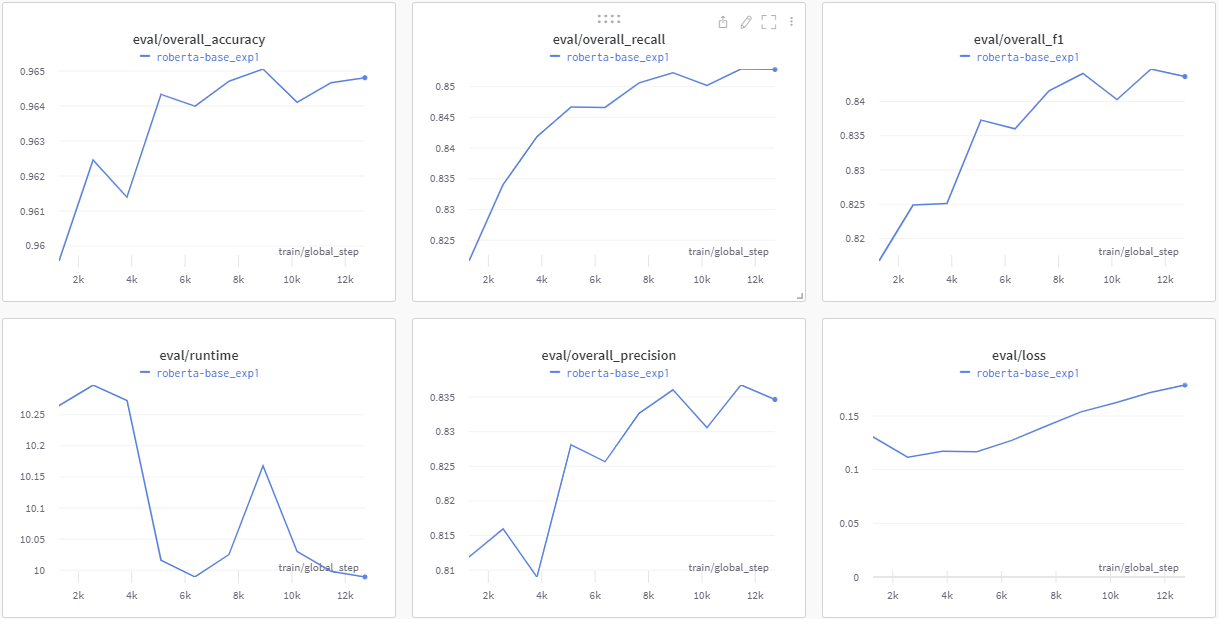

In [ ]:
1274*7

8918

In [ ]:
model = AutoModelForTokenClassification.from_pretrained('/content/roberta-base-ner/checkpoint-8918')

In [ ]:
create_repo("roberta-base-finetuned-ner")

model.push_to_hub("roberta-base-finetuned-ner")

tokenizer.push_to_hub("roberta-base-finetuned-ner")

Configuration saved in /tmp/tmpszvqz6z7/config.json
Model weights saved in /tmp/tmpszvqz6z7/pytorch_model.bin
Uploading the following files to Gozdi/roberta-base-finetuned-ner: pytorch_model.bin,config.json
tokenizer config file saved in /tmp/tmpxva6of6u/tokenizer_config.json
Special tokens file saved in /tmp/tmpxva6of6u/special_tokens_map.json
Uploading the following files to Gozdi/roberta-base-finetuned-ner: vocab.json,tokenizer.json,tokenizer_config.json,special_tokens_map.json,merges.txt


CommitInfo(commit_url='https://huggingface.co/Gozdi/roberta-base-finetuned-ner/commit/1b2c04be594751d2ab293df05a6aec76a18374d5', commit_message='Upload tokenizer', commit_description='', oid='1b2c04be594751d2ab293df05a6aec76a18374d5', pr_url=None, pr_revision=None, pr_num=None)

#DeBERTav3 Experiment 1

In [ ]:
model_checkpoint = 'microsoft/deberta-v3-xsmall'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

New tokenized dataset needs to be made using DeBERTa tokenizer

In [ ]:
def tokenize_and_align(batch):
  tokenized_inputs = tokenizer(
      batch['text'], truncation=True, is_split_into_words=True
  )
  batch_labels = batch['labels']
  new_labels = []
  for i, labels in enumerate(batch_labels):
    #word_ids is a mapping from words to tokens 
    word_ids = tokenized_inputs.word_ids(i)
    new_labels.append(align_labels_with_tokens(labels, word_ids))

  tokenized_inputs['labels'] = new_labels
  return tokenized_inputs

In [ ]:
tokenized_dataset = dataset.map(
    tokenize_and_align,
    batched=True,
    remove_columns=dataset['train'].column_names
)

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

For some reason printing model's summary doesn't work with DeBERTa

In [ ]:
summary(model, input_size=(2, 512), dtypes=['torch.IntTensor'])

RuntimeError: ignored

Hyperparameters

Learning rate: 3e-5

Epochs: 10

Weight decay: 0.01

Batch size: 32

Learning rate decay: Linear decaying to 0

Optimizer: AdamW with default settings

Warmup steps: 500

I chose these hyperparameters basing on table 10 on last page of DeBERTAv3 paper https://arxiv.org/pdf/2111.09543.pdf

In table 10 authors list hyperparameters they used for fine-tuning, they didn't share their choices for xsmall variant but except for learning rate they were the same for all variants so I assumed they wouldn't differ for xsmall.

In [ ]:
batch_size = 32
num_train_epochs = 10
logging_steps = 300
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    output_dir=f"{model_name}-ner",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    lr_scheduler_type='linear',
    num_train_epochs=num_train_epochs,
    logging_steps=logging_steps,
    report_to="wandb",
    run_name=model_name,
    logging_strategy='steps',
    save_strategy='epoch',
    logging_first_step=True,
    warmup_steps=500,
    gradient_accumulation_steps=1

)

PyTorch: setting up devices


In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 40754
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 12740
  Number of trainable parameters = 70686347
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
1,0.361400,0.301189,0.603350,0.589190,0.596186,0.915583
2,0.233600,0.201520,0.672531,0.722823,0.696771,0.937817
3,0.186500,0.176018,0.726291,0.744042,0.735059,0.944686
4,0.160600,0.158968,0.733372,0.777602,0.754839,0.950165
5,0.141400,0.150680,0.759038,0.782527,0.770603,0.952532
6,0.132800,0.142166,0.767319,0.795963,0.781379,0.955549
7,0.121400,0.139108,0.777699,0.797179,0.787318,0.956815
8,0.115900,0.139288,0.778090,0.807089,0.792324,0.956644
9,0.111000,0.137935,0.776139,0.806055,0.790814,0.957158
10,0.108600,0.137410,0.780052,0.808791,0.794162,0.957691


***** Running Evaluation *****
  Num examples = 7192
  Batch size = 32
Saving model checkpoint to deberta-v3-xsmall-ner/checkpoint-1274
Configuration saved in deberta-v3-xsmall-ner/checkpoint-1274/config.json
Model weights saved in deberta-v3-xsmall-ner/checkpoint-1274/pytorch_model.bin
tokenizer config file saved in deberta-v3-xsmall-ner/checkpoint-1274/tokenizer_config.json
Special tokens file saved in deberta-v3-xsmall-ner/checkpoint-1274/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 7192
  Batch size = 32
Saving model checkpoint to deberta-v3-xsmall-ner/checkpoint-2548
Configuration saved in deberta-v3-xsmall-ner/checkpoint-2548/config.json
Model weights saved in deberta-v3-xsmall-ner/checkpoint-2548/pytorch_model.bin
tokenizer config file saved in deberta-v3-xsmall-ner/checkpoint-2548/tokenizer_config.json
Special tokens file saved in deberta-v3-xsmall-ner/checkpoint-2548/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 7192
  Batch

TrainOutput(global_step=12740, training_loss=0.19258216563349054, metrics={'train_runtime': 1486.0365, 'train_samples_per_second': 274.246, 'train_steps_per_second': 8.573, 'total_flos': 2413995772073028.0, 'train_loss': 0.19258216563349054, 'epoch': 10.0})

#DeBERTav3 experiment 1 results

DeBERTa wasn't able to beat RoBERTa's results. DeBERTa best results were behind by 5% on recall, f1 and precision. In accuracy the difference is smaller that 1%. The best results were obtained after final epoch suggesting that longer training  may have been beneficial. Train runtime was 9% longer for DeBERTa. DeBERTa also requires more GPU memory to be allocated.

https://wandb.ai/gozdi/ner?workspace=user-gozdi

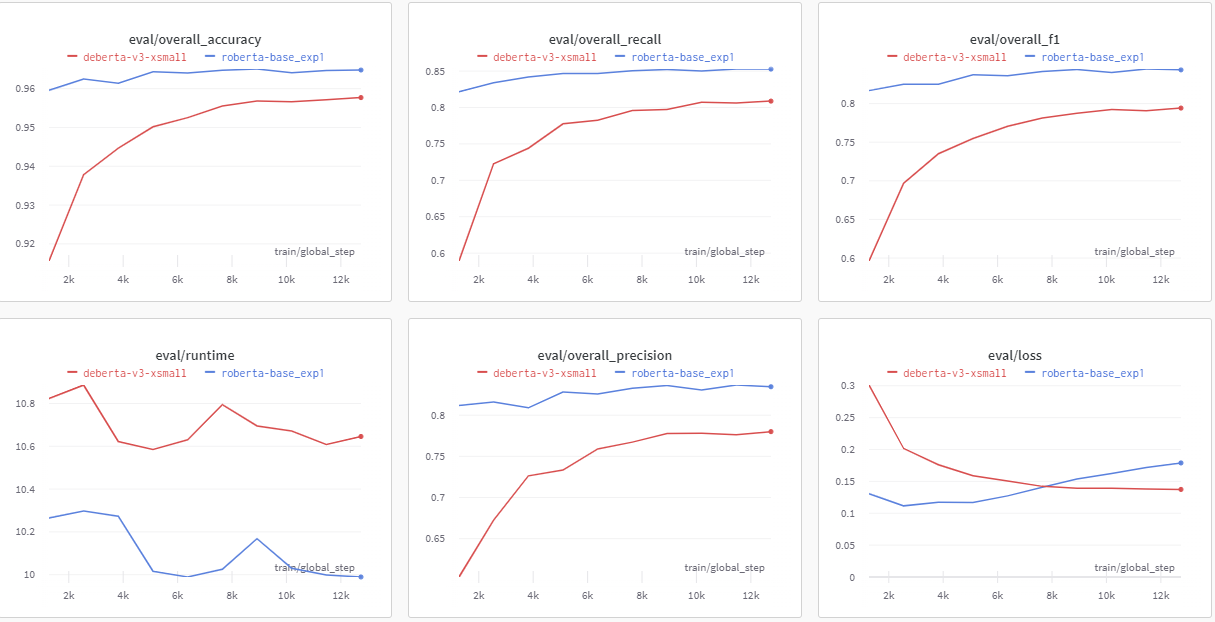

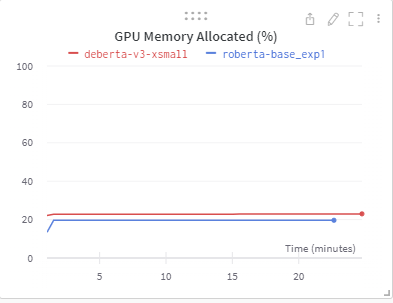

In [ ]:
wandb.finish()

In [ ]:
model = AutoModelForTokenClassification.from_pretrained('/content/deberta-v3-xsmall-ner/checkpoint-12740')

In [ ]:
create_repo("deberta_v3_xsmall-finetuned-ner-exp1")

model.push_to_hub("deberta_v3_xsmall-finetuned-ner-exp1")

tokenizer.push_to_hub("deberta_v3_xsmall-finetuned-ner-exp1")

#DeBERTav3 Experiment 2

For this experiment I increased learning rate from 0.00003 to 0.00005 and doubled the batch size to 64

All the other hyperparameters did not change

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

In [ ]:
batch_size = 64
num_train_epochs = 10
logging_steps = 300
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    output_dir=f"{model_name}-ner_exp2",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    lr_scheduler_type='linear',
    num_train_epochs=num_train_epochs,
    logging_steps=logging_steps,
    report_to="wandb",
    run_name=f'{model_name}_exp2',
    logging_strategy='steps',
    save_strategy='epoch',
    logging_first_step=True,
    warmup_steps=500,
    gradient_accumulation_steps=1

)

PyTorch: setting up devices


In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 40754
  Num Epochs = 10
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 6370
  Number of trainable parameters = 70686347
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
1,0.451600,0.313414,0.541269,0.561770,0.551329,0.908927
2,0.239000,0.201655,0.665277,0.727566,0.695028,0.937646
3,0.183200,0.163673,0.736039,0.756445,0.746102,0.948106
4,0.153900,0.148393,0.750552,0.784959,0.767370,0.952733
5,0.136100,0.141558,0.771214,0.794565,0.782715,0.955484
6,0.126000,0.141825,0.763377,0.803198,0.782781,0.955839
7,0.114600,0.137379,0.781375,0.807028,0.793994,0.958046
8,0.107800,0.142834,0.763402,0.812135,0.787015,0.954999
9,0.100300,0.136961,0.783489,0.816452,0.799631,0.958419
10,0.098700,0.137547,0.780563,0.815965,0.797872,0.957969


***** Running Evaluation *****
  Num examples = 7192
  Batch size = 64
Saving model checkpoint to deberta-v3-xsmall-ner_exp2/checkpoint-637
Configuration saved in deberta-v3-xsmall-ner_exp2/checkpoint-637/config.json
Model weights saved in deberta-v3-xsmall-ner_exp2/checkpoint-637/pytorch_model.bin
tokenizer config file saved in deberta-v3-xsmall-ner_exp2/checkpoint-637/tokenizer_config.json
Special tokens file saved in deberta-v3-xsmall-ner_exp2/checkpoint-637/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 7192
  Batch size = 64
Saving model checkpoint to deberta-v3-xsmall-ner_exp2/checkpoint-1274
Configuration saved in deberta-v3-xsmall-ner_exp2/checkpoint-1274/config.json
Model weights saved in deberta-v3-xsmall-ner_exp2/checkpoint-1274/pytorch_model.bin
tokenizer config file saved in deberta-v3-xsmall-ner_exp2/checkpoint-1274/tokenizer_config.json
Special tokens file saved in deberta-v3-xsmall-ner_exp2/checkpoint-1274/special_tokens_map.json
***** Running E

TrainOutput(global_step=6370, training_loss=0.19603221536244103, metrics={'train_runtime': 924.0672, 'train_samples_per_second': 441.029, 'train_steps_per_second': 6.893, 'total_flos': 2603878186495044.0, 'train_loss': 0.19603221536244103, 'epoch': 10.0})

#DeBERTav3 experiment 2 results

Doubeling the batch size halved the number of steps which resulted in shorter training time. Higher batch size combined with higher learning rate yielded better slightly results on recall (+0.8%) and f1 (+0.6%), on accuracy and precision they are the same. Best results were achieved after 9 epochs of training

https://wandb.ai/gozdi/ner?workspace=user-gozdi

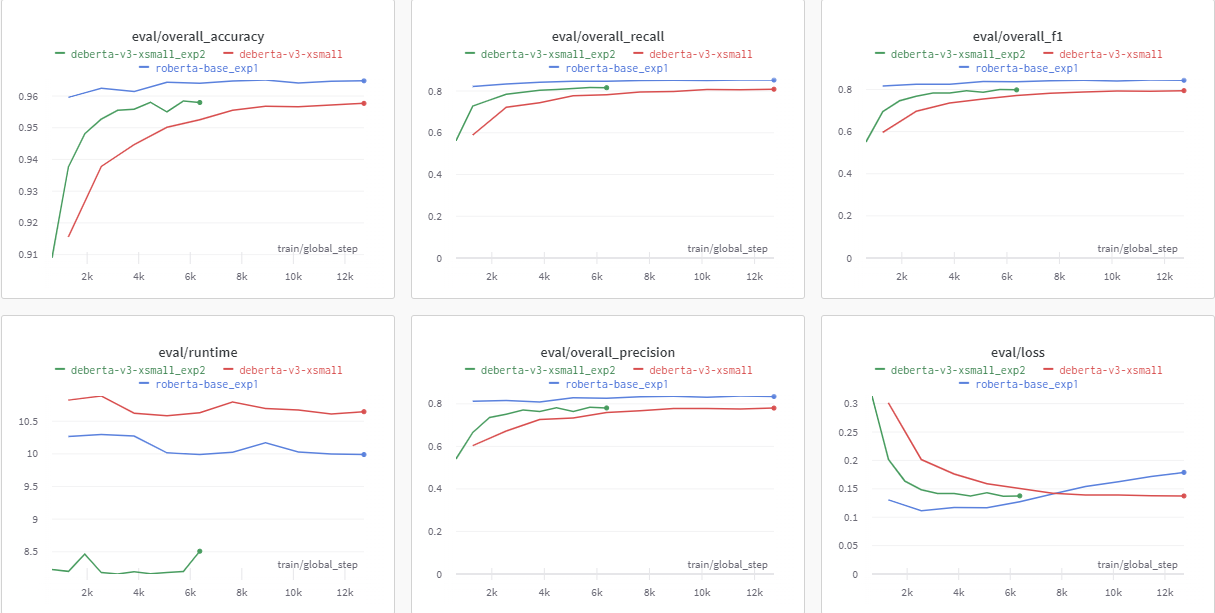

In [ ]:
wandb.finish()

eval/loss,█▄▂▁▁▁▁▁▁▁
eval/overall_accuracy,▁▅▇▇██████
eval/overall_f1,▁▅▆▇██████
eval/overall_precision,▁▅▇▇█▇█▇██
eval/overall_recall,▁▆▆▇▇█████
eval/runtime,▂▂▇▁▁▂▁▁▂█
eval/samples_per_second,▇▇▂██▇██▇▁
eval/steps_per_second,▇▇▂██▇██▇▁
train/epoch,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇████
train/learning_rate,▁▅██▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▁▁


In [ ]:
model = AutoModelForTokenClassification.from_pretrained('/content/deberta-v3-xsmall-ner_exp2/checkpoint-5733')

In [ ]:
create_repo("deberta_v3_xsmall-finetuned-ner-exp2")

model.push_to_hub("deberta_v3_xsmall-finetuned-ner-exp2")

tokenizer.push_to_hub("deberta_v3_xsmall-finetuned-ner-exp2")

#Conclusions 

DeBERTa wasn't able to outperform RoBERTa on this NER task but considering only backbone size difference, DeBERTa's performance is impresive. Nevertheless, despite bigger backbone size RoBERTa trained faster and achieved better results, so it would be a better option for this particular task if model's size isn't a concerne.